In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras._impl.keras.layers import Input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten,
                                            MaxPool2D)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import to_categorical
%matplotlib inline
import datetime

In [2]:
BATCH_SIZE = 256
EPOCHS = 27
now = str(datetime.datetime.now())
CHECKPOINT_NAME = '_'.join(('checkpoint ' + now).split(' '))
print(CHECKPOINT_NAME)


checkpoint_2018-03-21_07:17:58.797842


Read data and add it to a csv

In [3]:
def load_data(test=False, mode=0, rgb=False):
    files = ['fer2013/training.csv',
             'fer2013/publictest.csv',
             'fer2013/privatetest.csv']
    
    data = pd.read_csv(files[mode])
    
    data['pixels'] = data['pixels'].apply(lambda img: np.fromstring(img, sep=' '))
    X = np.vstack(data['pixels'].values)
    # #normalize data
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    if rgb: # transform data cu rgb if needed
        X = cv2.cvtColor(data['pixels'], cv2.COLOR_GRAY2RGB)
        X = X.reshape(-1, 48, 48, 3)
    else:
        X = X.reshape(-1, 48, 48, 1)

    print(X.shape)
    
    if not test:
        y = data['emotion'].values
        y = y.astype(np.int)
        y = to_categorical(y)
    else:
        y = None

    return X, y


In [4]:
checkpointer = ModelCheckpoint(filepath='checkpoints/{0}.h5'.format(CHECKPOINT_NAME), verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BATCH_SIZE, write_images=True)

model_callbacks = [checkpointer, early_stop, tensorboard]

In [5]:
model = Sequential()
model.add(Conv2D(64, 3, input_shape=(48, 48, 1), activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 32)        9248      
__________

In [6]:
X,y = load_data(mode=0)
X_validation, y_validation = load_data(mode=1)
hist = model.fit(X, y, shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE,
                 callbacks=model_callbacks, verbose=1,
                 validation_data=(X_validation, y_validation))

(28709, 48, 48, 1)
(3589, 48, 48, 1)
Train on 28709 samples, validate on 3589 samples
Epoch 1/27
28709/28709 [==============================] - 116s - loss: 1.7676 - acc: 0.2777 - val_loss: 1.5964 - val_acc: 0.3859
Epoch 2/27
28709/28709 [==============================] - 114s - loss: 1.6072 - acc: 0.3726 - val_loss: 1.4770 - val_acc: 0.4441
Epoch 3/27
28709/28709 [==============================] - 116s - loss: 1.5020 - acc: 0.4189 - val_loss: 1.4007 - val_acc: 0.4634
Epoch 4/27
28709/28709 [==============================] - 114s - loss: 1.4262 - acc: 0.4497 - val_loss: 1.3370 - val_acc: 0.4951
Epoch 5/27
28709/28709 [==============================] - 114s - loss: 1.3666 - acc: 0.4797 - val_loss: 1.2631 - val_acc: 0.5208
Epoch 6/27
28709/28709 [==============================] - 115s - loss: 1.3114 - acc: 0.4994 - val_loss: 1.2449 - val_acc: 0.5266
Epoch 7/27
28709/28709 [==============================] - 114s - loss: 1.2745 - acc: 0.5185 - val_loss: 1.2318 - val_acc: 0.5291
Epoch 8/27


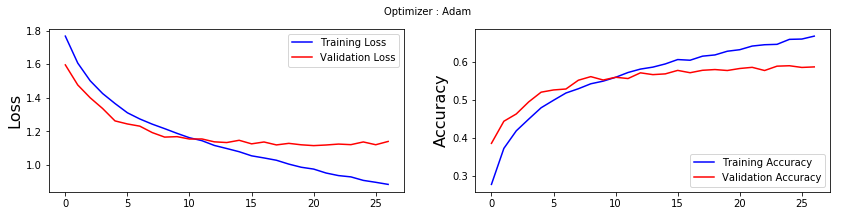

In [7]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [8]:
x_eval, y_eval = load_data(mode=2)

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)
model.save_weights('models/{0}.h5'.format(CHECKPOINT_NAME))

(3589, 48, 48, 1)
3584/3589 [============================>.] - ETA: 0sScore :  1.10818617833
Accuracy :  58.8186124285


In [9]:
x_eval, y_eval = load_data(mode=2)
model.load_weights('checkpoints/{0}.h5'.format(CHECKPOINT_NAME))

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)

(3589, 48, 48, 1)
3584/3589 [============================>.] - ETA: 0sScore :  1.09172889176
Accuracy :  59.9052660942
